##**Importing Libraries**

In [2]:
!pip install kaggle


In [3]:

import os
os.makedirs('/root/.kaggle/', exist_ok=True)

In [4]:
!cp kaggle.json /root/.kaggle/

In [5]:
# Use the correct file path if the file was uploaded
!cp /content/kaggle.json /root/.kaggle/

# Set permissions to secure your Kaggle API key
!chmod 600 /root/.kaggle/kaggle.json

In [6]:
!kaggle datasets download -d veeralakrishna/butterfly-dataset

Dataset URL: https://www.kaggle.com/datasets/veeralakrishna/butterfly-dataset
License(s): Community Data License Agreement - Permissive - Version 1.0
 98% 446M/454M [00:04<00:00, 87.4MB/s]
100% 454M/454M [00:04<00:00, 98.2MB/s]


In [7]:
!unzip "/content/butterfly-dataset.zip"

Archive:  /content/butterfly-dataset.zip
  inflating: leedsbutterfly/README.txt  
  inflating: leedsbutterfly/descriptions/001.txt  
  inflating: leedsbutterfly/descriptions/002.txt  
  inflating: leedsbutterfly/descriptions/003.txt  
  inflating: leedsbutterfly/descriptions/004.txt  
  inflating: leedsbutterfly/descriptions/005.txt  
  inflating: leedsbutterfly/descriptions/006.txt  
  inflating: leedsbutterfly/descriptions/007.txt  
  inflating: leedsbutterfly/descriptions/008.txt  
  inflating: leedsbutterfly/descriptions/009.txt  
  inflating: leedsbutterfly/descriptions/010.txt  
  inflating: leedsbutterfly/images/0010001.png  
  inflating: leedsbutterfly/images/0010002.png  
  inflating: leedsbutterfly/images/0010004.png  
  inflating: leedsbutterfly/images/0010005.png  
  inflating: leedsbutterfly/images/0010006.png  
  inflating: leedsbutterfly/images/0010007.png  
  inflating: leedsbutterfly/images/0010008.png  
  inflating: leedsbutterfly/images/0010009.png  
  inflating: lee

In [8]:
import os
import numpy as np
import re
import cv2
import time
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from PIL import Image
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Conv2DTranspose, concatenate, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from sklearn.model_selection import train_test_split

##**Load Dataset**

In [9]:
# Path to the dataset directories
image_path = "/content/leedsbutterfly/images"
mask_path = "/content/leedsbutterfly/segmentations"

In [10]:
# List images and masks
images = os.listdir(image_path)
masks = os.listdir(mask_path)

In [11]:
# Function to find the corresponding mask for a given image
def get_corresponding_mask(image_name):
    base_name = image_name.split(".")[0] # Extract base name (e.g., '0010001')
    mask_name = f"{base_name}_seg0.png" # Append '_seg0' to match the mask pattern
    return mask_name

In [12]:
# Display a few sample images and their corresponding masks
def show_samples(image_list, num_samples = 3):
    plt.figure(figsize = (10, 10))
    for i in range(num_samples):
        img = Image.open(os.path.join(image_path, image_list[i]))
        mask_name = get_corresponding_mask(image_list[i])
        mask = Image.open(os.path.join(mask_path, mask_name))

        plt.subplot(2, num_samples, i + 1)
        plt.imshow(img)
        plt.title("Image")
        plt.axis("off")

        plt.subplot(2, num_samples, num_samples + i + 1)
        plt.imshow(mask)
        plt.title("Mask")
        plt.axis("off")

    plt.show()

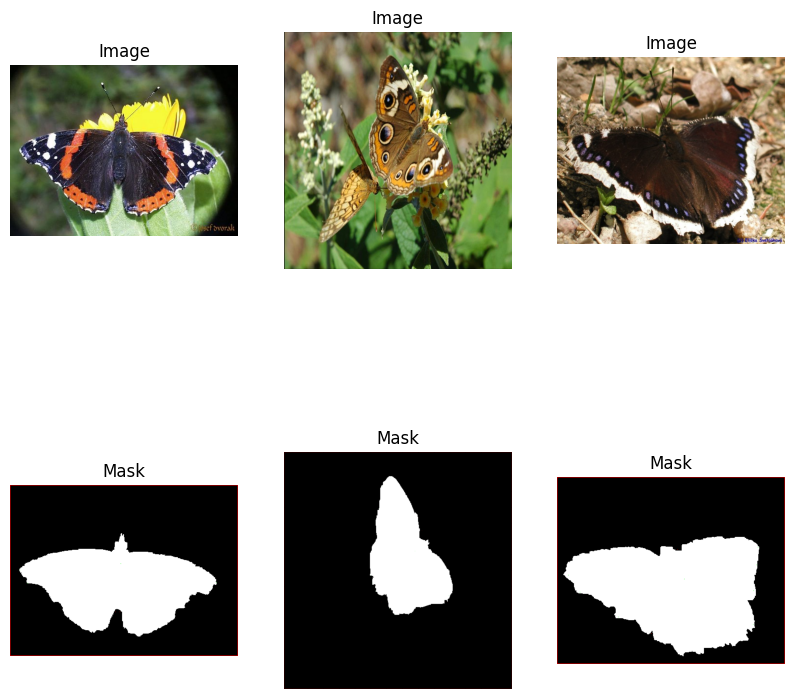

In [13]:
show_samples(images, num_samples = 3)

In [14]:
# Function to load and preprocess the dataset
def load_data(image_dir, mask_dir, image_shape=256):
    """
    Loads and preprocesses images and masks for training.

    Args:
        image_dir (str): Directory containing the images.
        mask_dir (str): Directory containing the masks.
        image_shape (int, optional): Shape to resize the images and masks. Defaults to 256.

    Returns:
        tuple: Arrays of preprocessed images and masks.
    """
    image_list = []
    mask_list = []

    # Create a dictionary as well, in which we have key as the original image and mask as the value.


    image_names = os.listdir(image_dir)
    mask_names = [re.sub(r'\.png', '_seg0.png', name) for name in image_names]

    for img_name, mask_name in zip(image_names, mask_names):
        try:
            img = plt.imread(os.path.join(image_dir, img_name))
            mask = plt.imread(os.path.join(mask_dir, mask_name))
        except FileNotFoundError:
            print("Exception hapened as the file is not found.")
            continue

        # Resizing the images and masks
        img_resized = cv2.resize(img, (image_shape, image_shape))
        mask_resized = cv2.resize(mask, (image_shape, image_shape))

        # Storing the preprocessed data
        image_list.append(img_resized)
        mask_list.append(mask_resized[:, :, 0])  # Use the first channel for binary masks

    return np.array(image_list), np.array(mask_list)

In [15]:
image_dir = "/content/leedsbutterfly/images"
mask_dir = "/content/leedsbutterfly/segmentations"
images, mask = load_data(image_dir, mask_dir)

In [16]:
images.shape, mask.shape

((832, 256, 256, 3), (832, 256, 256))

###**Train Test Split**

In [17]:
# Split the data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(images, mask, test_size = 0.2, random_state = 42)

In [18]:
print(X_train.shape, X_val.shape, y_train.shape, y_val.shape)

(665, 256, 256, 3) (167, 256, 256, 3) (665, 256, 256) (167, 256, 256)


In [19]:
# try to do imread on these numpy arrays and then imshow on these.
X_train[0], y_train[0]

(array([[[0.5137255 , 0.70980394, 0.51265323],
         [0.52299327, 0.7033854 , 0.51122856],
         [0.52299327, 0.7033854 , 0.51122856],
         ...,
         [0.4671569 , 0.5416667 , 0.32598042],
         [0.5045055 , 0.5628082 , 0.3672506 ],
         [0.55651045, 0.5839614 , 0.4231771 ]],
 
        [[0.49411765, 0.70980394, 0.48697916],
         [0.5062347 , 0.7023131 , 0.50231314],
         [0.5062347 , 0.7023131 , 0.50231314],
         ...,
         [0.49675247, 0.5712623 , 0.355576  ],
         [0.5452413 , 0.5818727 , 0.39415824],
         [0.5894149 , 0.59725803, 0.44431677]],
 
        [[0.48235294, 0.7019608 , 0.45765334],
         [0.46780026, 0.6959712 , 0.4545956 ],
         [0.49353555, 0.69425553, 0.46072304],
         ...,
         [0.51662076, 0.5883732 , 0.35917586],
         [0.5560355 , 0.6053615 , 0.40588236],
         [0.61496633, 0.6092831 , 0.45562193]],
 
        ...,
 
        [[0.85882354, 0.22528172, 0.47034615],
         [0.84664524, 0.22167586, 0.48514

##**Building UNET Architecture**

###**Building Convolution Block**

In [20]:
# Function to create a convolutional block for the U-Net model
def convolution_block(input_tensor, num_filters, kernel_size = 3, use_batch_norm = True):
    """
    Performs two convolution operations with optional batch normalization.

    Args:
        input_tensor (tensor): Input to the convolutional block.
        num_filters (int): Number of filters for the convolutional layers.
        kernel_size (int, optional): Size of the convolution kernel. Defaults to 3.
        use_batch_norm (bool, optional): Apply batch normalization if True. Defaults to True.

    Returns:
        tensor: Output after applying convolution, batch normalization, and activation.
    """
    # First Convolution
    x = tf.keras.layers.Conv2D(filters = num_filters, kernel_size = (kernel_size, kernel_size),
                               kernel_initializer = 'he_normal', padding = 'same')(input_tensor)
    if use_batch_norm:
      x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation('relu')(x)

    # Second convolution
    x = tf.keras.layers.Conv2D(filters=num_filters, kernel_size=(kernel_size, kernel_size),
                               kernel_initializer='he_normal', padding='same')(x)
    if use_batch_norm:
        x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation('relu')(x)

    return x

###**Building UNET Model**

In [21]:
# Function to create a U-Net model
def build_unet(input_shape, num_filters = 16, dropout_rate = 0.1, use_batch_norm = True):
    """
    Builds a U-Net model.

    Args:
        input_shape (tuple): Shape of the input image (height, width, channels).
        num_filters (int, optional): Number of filters for the initial layer. Defaults to 16.
        dropout_rate (float, optional): Dropout rate for regularization. Defaults to 0.1.
        use_batch_norm (bool, optional): Apply batch normalization if True. Defaults to True.

    Returns:
        keras.Model: Compiled U-Net model.
    """
    inputs = tf.keras.layers.Input(shape = input_shape)

    # Encoder
    c1 = convolution_block(inputs, num_filters * 1, use_batch_norm = use_batch_norm)
    p1 = tf.keras.layers.MaxPooling2D((2, 2))(c1)
    p1 = tf.keras.layers.Dropout(dropout_rate)(p1)

    c2 = convolution_block(p1, num_filters * 2, use_batch_norm = use_batch_norm)
    p2 = tf.keras.layers.MaxPooling2D((2, 2))(c2)
    p2 = tf.keras.layers.Dropout(dropout_rate)(p2)

    c3 = convolution_block(p2, num_filters * 4, use_batch_norm = use_batch_norm)
    p3 = tf.keras.layers.MaxPooling2D((2, 2))(c3)
    p3 = tf.keras.layers.Dropout(dropout_rate)(p3)

    c4 = convolution_block(p3, num_filters * 8, use_batch_norm = use_batch_norm)
    p4 = tf.keras.layers.MaxPooling2D((2, 2))(c4)
    p4 = tf.keras.layers.Dropout(dropout_rate)(p4)

    # BottleNeck
    c5 = convolution_block(p4, num_filters * 16, use_batch_norm = use_batch_norm)

    # Decoder
    u6 = tf.keras.layers.Conv2DTranspose(num_filters * 8, (3, 3), strides=(2, 2), padding='same')(c5)
    u6 = tf.keras.layers.concatenate([u6, c4])
    u6 = tf.keras.layers.Dropout(dropout_rate)(u6)
    c6 = convolution_block(u6, num_filters * 8, use_batch_norm=use_batch_norm)

    u7 = tf.keras.layers.Conv2DTranspose(num_filters * 4, (3, 3), strides=(2, 2), padding='same')(c6)
    u7 = tf.keras.layers.concatenate([u7, c3])
    u7 = tf.keras.layers.Dropout(dropout_rate)(u7)
    c7 = convolution_block(u7, num_filters * 4, use_batch_norm=use_batch_norm)

    u8 = tf.keras.layers.Conv2DTranspose(num_filters * 2, (3, 3), strides=(2, 2), padding='same')(c7)
    u8 = tf.keras.layers.concatenate([u8, c2])
    u8 = tf.keras.layers.Dropout(dropout_rate)(u8)
    c8 = convolution_block(u8, num_filters * 2, use_batch_norm=use_batch_norm)

    u9 = tf.keras.layers.Conv2DTranspose(num_filters * 1, (3, 3), strides=(2, 2), padding='same')(c8)
    u9 = tf.keras.layers.concatenate([u9, c1])
    u9 = tf.keras.layers.Dropout(dropout_rate)(u9)
    c9 = convolution_block(u9, num_filters * 1, use_batch_norm=use_batch_norm)

    # Output Layer
    output = tf.keras.layers.Conv2D(1, (1, 1), activation = 'sigmoid')(c9)

    # Model Creation
    model = tf.keras.Model(inputs = [inputs], outputs = [output])
    return model

In [22]:
# Instantiate and compile the U-Net model
input_shape = (256, 256, 3)
unet_model = build_unet(input_shape, dropout_rate = 0.07)
unet_model.compile(optimizer = 'Adam', loss = 'binary_crossentropy', metrics = ['accuracy'])

In [23]:
unet_model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 256, 256, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 256, 256, 16)   │            448 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization       │ (None, 256, 256, 16)   │             64 │ conv2d[0][0]           │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation (Activation)   │ (None, 256, 256, 16)   │              0 │ batch_normalization[0… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_1 (Conv2D)         │ (None, 256, 256, 16)   │          2,320 │ activation[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_1     │ (None, 256, 256, 16)   │             64 │ conv2d_1[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_1 (Activation) │ (None, 256, 256, 16)   │              0 │ batch_normalization_1… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d             │ (None, 128, 128, 16)   │              0 │ activation_1[0][0]     │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout (Dropout)         │ (None, 128, 128, 16)   │              0 │ max_pooling2d[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_2 (Conv2D)         │ (None, 128, 128, 32)   │          4,640 │ dropout[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_2     │ (None, 128, 128, 32)   │            128 │ conv2d_2[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_2 (Activation) │ (None, 128, 128, 32)   │              0 │ batch_normalization_2… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_3 (Conv2D)         │ (None, 128, 128, 32)   │          9,248 │ activation_2[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_3     │ (None, 128, 128, 32)   │            128 │ conv2d_3[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_3 (Activation) │ (None, 128, 128, 32)   │              0 │ batch_normalization_3… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_1           │ (None, 64, 64, 32)     │              0 │ activation_3[0][0]     │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_1 (Dropout)  

 Total params: 2,164,593 (8.26 MB)

 Trainable params: 2,161,649 (8.25 MB)

 Non-trainable params: 2,944 (11.50 KB)

In [24]:
!pip install visualkeras

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 993.7/993.7 kB 17.4 MB/s eta 0:00:00


/usr/local/lib/python3.10/dist-packages/visualkeras/layered.py:86: UserWarning: The legend_text_spacing_offset parameter is deprecated and will be removed in a future release.
  warnings.warn("The legend_text_spacing_offset parameter is deprecated and will be removed in a future release.")


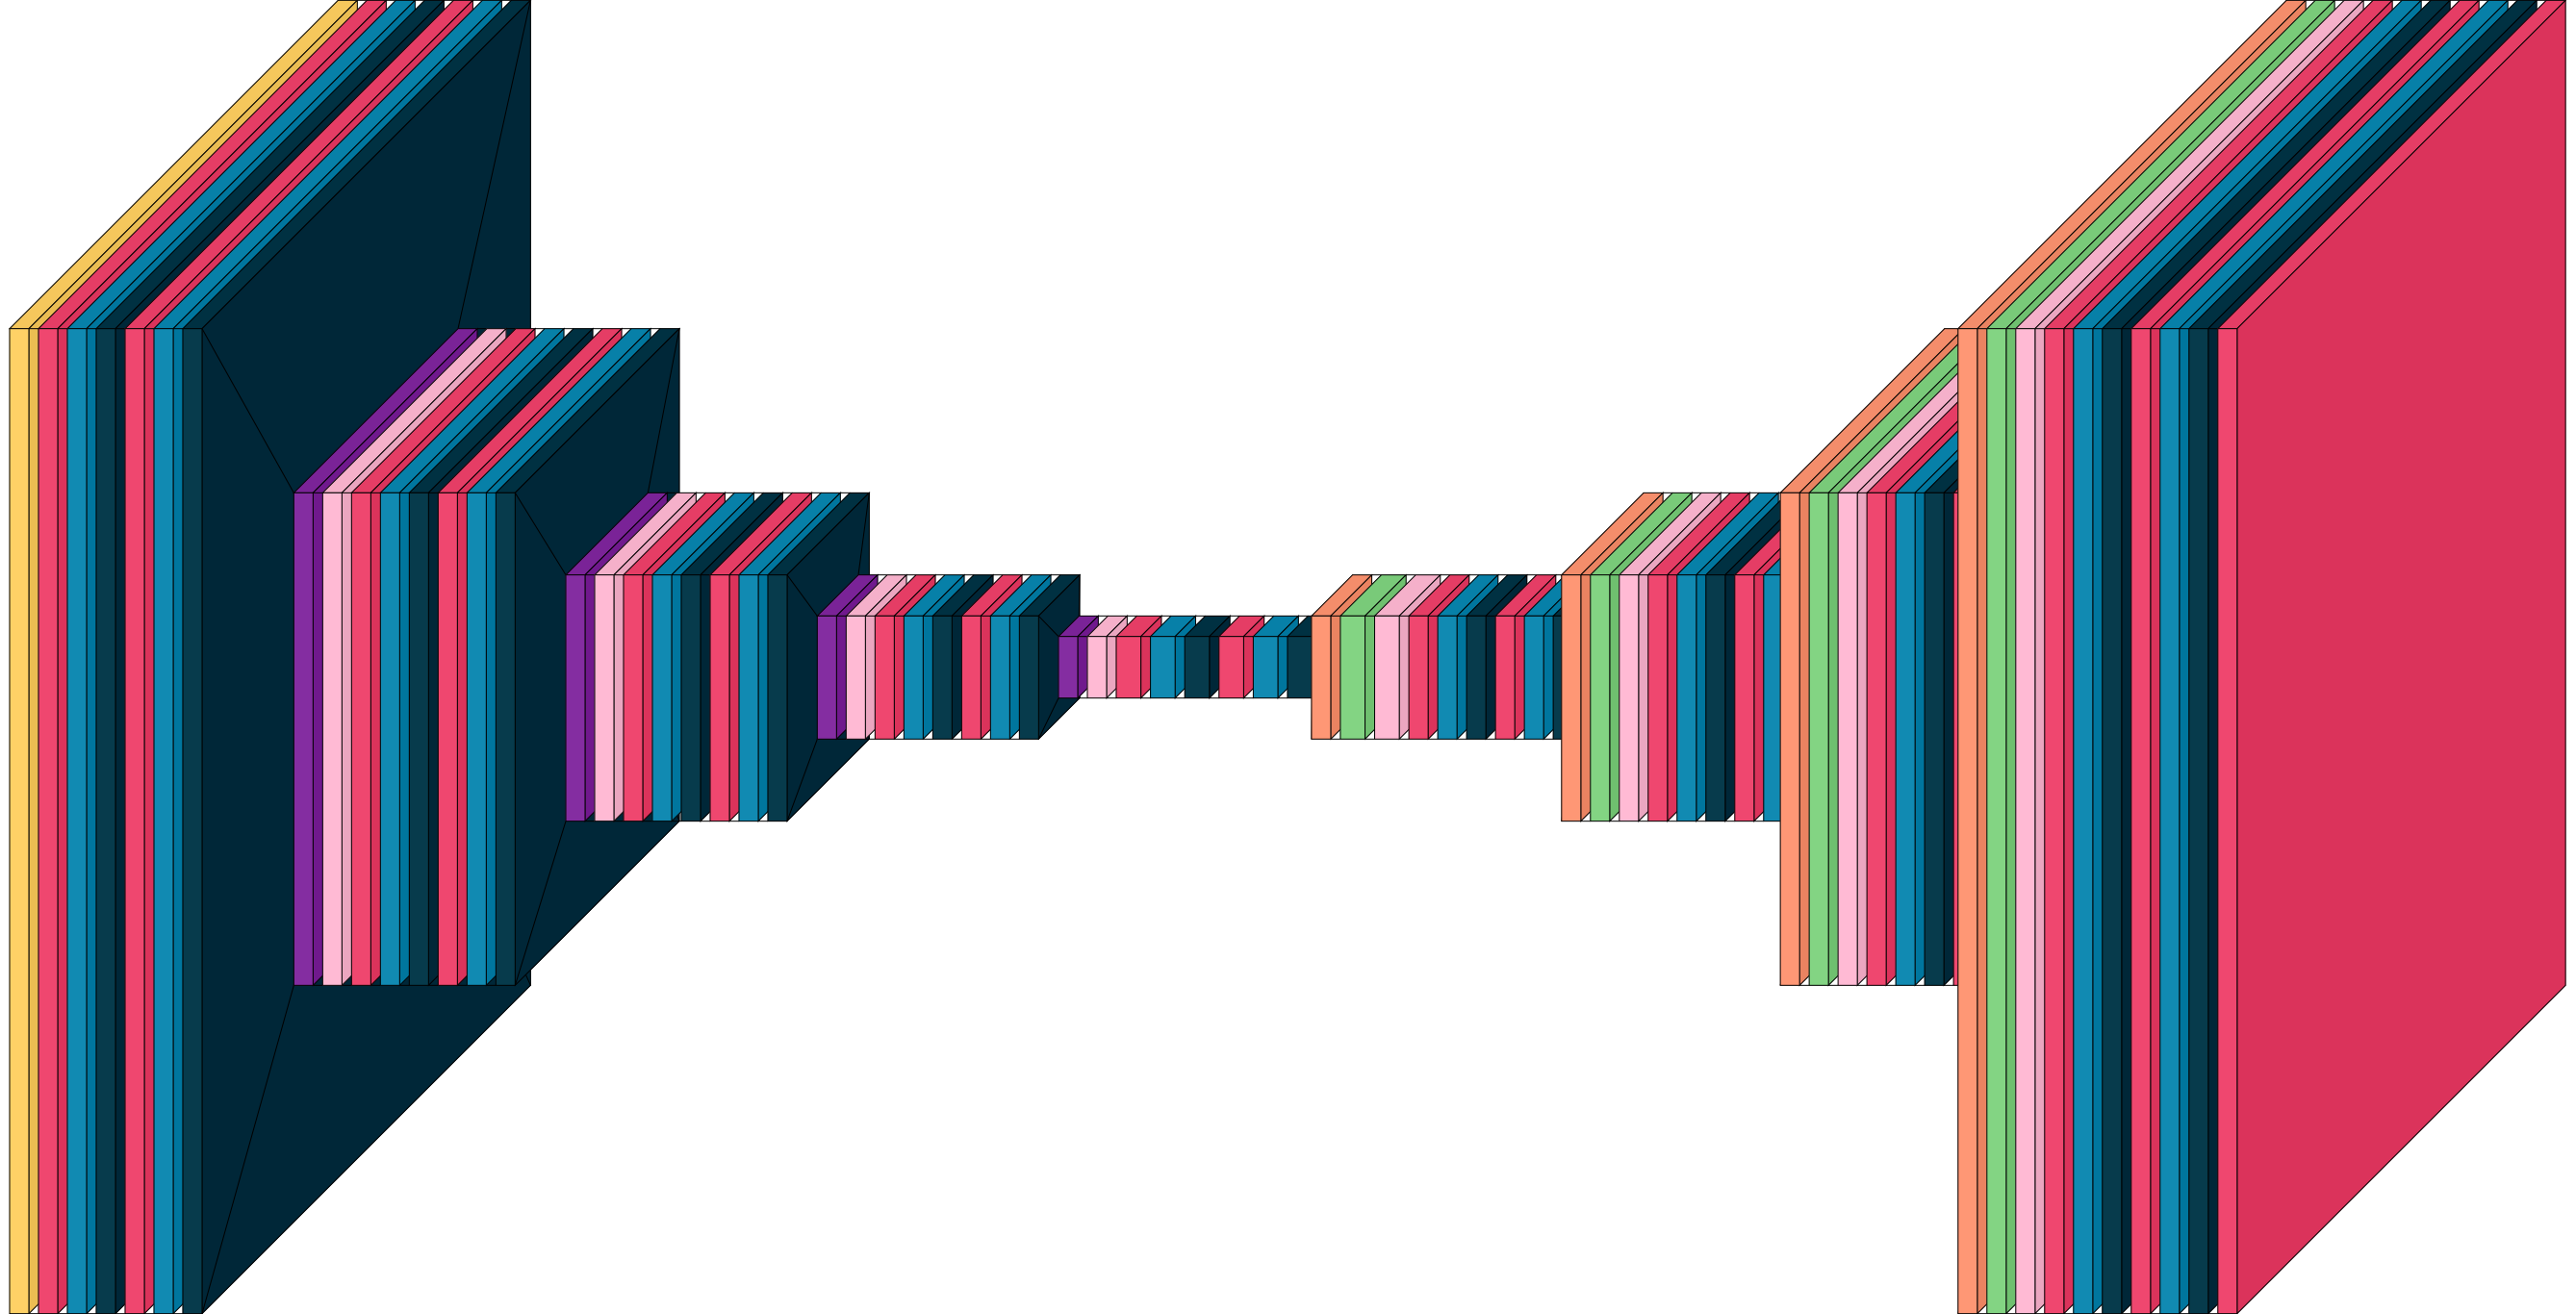

In [25]:
import visualkeras
from visualkeras import layered_view
visualkeras.layered_view(unet_model)

In [26]:
# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=10, verbose=1, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, verbose=1, min_lr=1e-6)
model_checkpoint = ModelCheckpoint('unet_model_best.keras', monitor='val_loss', save_best_only=True, verbose=1)

In [27]:
# Train the model
history = unet_model.fit(X_train,
                         y_train,
                         validation_data=(X_val, y_val),
                         epochs=50,
                         verbose=1,
                         callbacks=[early_stopping, reduce_lr, model_checkpoint])

Epoch 1/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.7570 - loss: 0.5156   
Epoch 1: val_loss improved from inf to 1.34267, saving model to unet_model_best.keras
21/21 ━━━━━━━━━━━━━━━━━━━━ 125s 3s/step - accuracy: 0.7595 - loss: 0.5119 - val_accuracy: 0.6170 - val_loss: 1.3427 - learning_rate: 0.0010
Epoch 2/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 276ms/step - accuracy: 0.8816 - loss: 0.2941
Epoch 2: val_loss did not improve from 1.34267
21/21 ━━━━━━━━━━━━━━━━━━━━ 7s 308ms/step - accuracy: 0.8817 - loss: 0.2937 - val_accuracy: 0.3946 - val_loss: 8.0022 - learning_rate: 0.0010
Epoch 3/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 284ms/step - accuracy: 0.9044 - loss: 0.2298
Epoch 3: val_loss did not improve from 1.34267
21/21 ━━━━━━━━━━━━━━━━━━━━ 10s 306ms/step - accuracy: 0.9046 - loss: 0.2294 - val_accuracy: 0.5674 - val_loss: 4.3289 - learning_rate: 0.0010
Epoch 4/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 291ms/step - accuracy: 0.9194 - loss: 0.1889
Epoch 4: val_loss did not improve from 1.34267
21/21 

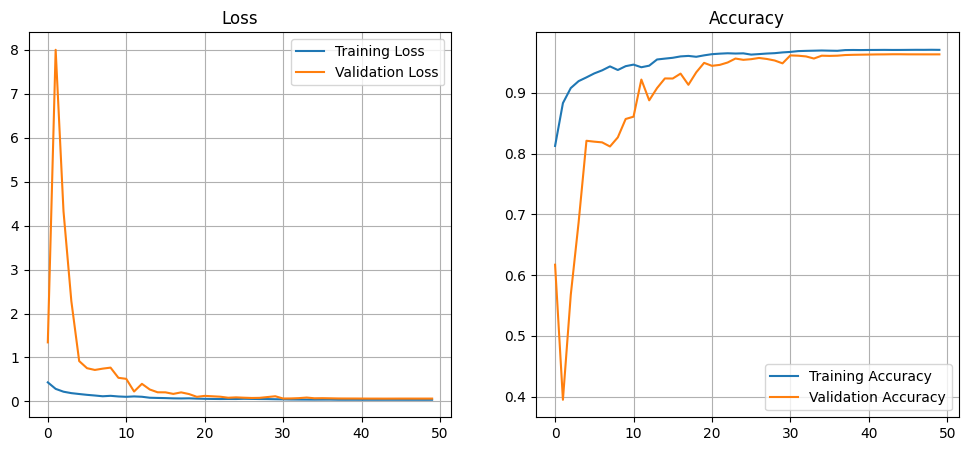

In [29]:
# Plot training and validation loss and accuracy
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.grid()
plt.title('Loss')

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.grid()
plt.title('Accuracy')

plt.show()

In [30]:
# Function to predict and time the inference for a single image
def predict_single_image(image, model):
    """
    Predicts the segmentation mask for a single image and times the prediction.

    Args:
        image (array): Input image for prediction.
        model (keras.Model): Trained U-Net model.

    Returns:
        tuple: Predicted mask and inference time.
    """
    start_time = time.time()
    prediction = model.predict(np.expand_dims(image, axis = 0))[0, :, :, 0]
    end_time = time.time()
    inference_time = end_time - start_time
    return prediction, inference_time

In [32]:
# Function to visualize the prediction and ground truth
def visualize_segmentation(image, predicted_mask, ground_truth_mask):
    """
    Visualizes the original image, predicted mask, and ground truth mask.

    Args:
        image (array): Original image.
        predicted_mask (array): Predicted mask.
        ground_truth_mask (array): Ground truth mask.
    """
    plt.figure(figsize=(12, 4))

    plt.subplot(1, 3, 1)
    plt.imshow(image)
    plt.title('Original Image')

    plt.subplot(1, 3, 2)
    plt.imshow(predicted_mask, cmap='gray')
    plt.title('Predicted Mask')

    plt.subplot(1, 3, 3)
    plt.imshow(ground_truth_mask, cmap='gray')
    plt.title('Ground Truth Mask')

    plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Inference time for single Image: 0.063712 seconds


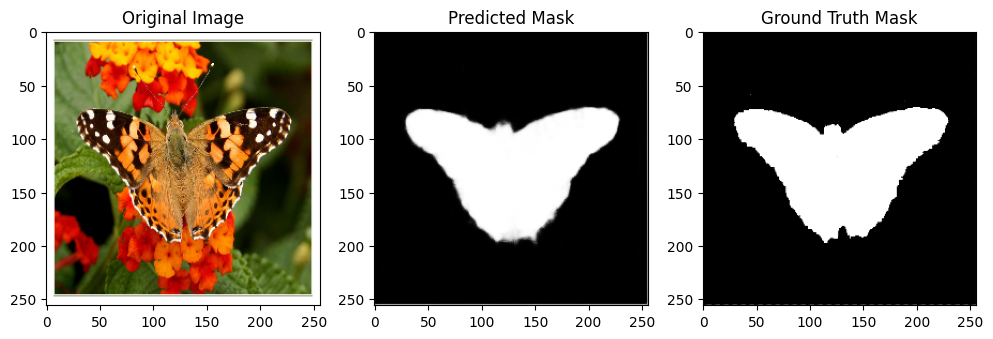

In [34]:
# Example inference on a validation image
sample_image = X_val[0]
sample_ground_truth = y_val[0]

predicted_mask, inference_time = predict_single_image(sample_image, unet_model)
print(f"Inference time for single Image: {inference_time:4f} seconds")

# Visualize the result
visualize_segmentation(sample_image, predicted_mask, sample_ground_truth)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Inference time for single Image: 0.090230 seconds


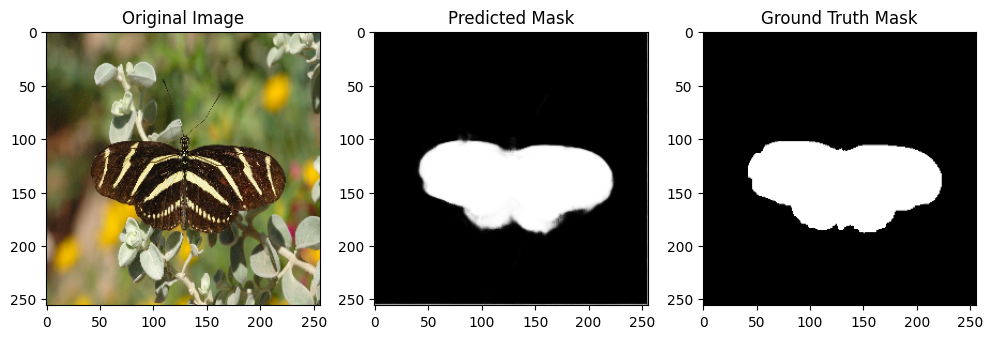

In [36]:
# Example inference on a validation image
sample_image = X_val[5]
sample_ground_truth = y_val[5]

predicted_mask, inference_time = predict_single_image(sample_image, unet_model)
print(f"Inference time for single Image: {inference_time:4f} seconds")

# Visualize the result
visualize_segmentation(sample_image, predicted_mask, sample_ground_truth)

###**Calculating Mean IOU Score**

In [37]:
import tensorflow.keras.backend as K
def mean_iou(y_true, y_pred, smooth=1):
    """
    Calculate the mean Intersection over Union (IoU).

    Args:
        y_true (tensor): Ground truth mask.
        y_pred (tensor): Predicted mask.
        smooth (float, optional): Smoothing factor to avoid division by zero. Defaults to 1.

    Returns:
        float: Mean IoU score.
    """
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    union = K.sum(y_true_f) + K.sum(y_pred_f) - intersection
    return (intersection + smooth) / (union + smooth)

In [38]:
# Get predictions
y_pred = unet_model.predict(X_val)
print(mean_iou(y_val,y_pred))

6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 184ms/step
tf.Tensor(0.8855167, shape=(), dtype=float32)


In [40]:
# Get predictions
y_pred = unet_model.predict(X_train)
print(mean_iou(y_train,y_pred))

21/21 ━━━━━━━━━━━━━━━━━━━━ 2s 114ms/step
tf.Tensor(0.91562486, shape=(), dtype=float32)


###**Adding IOU to the metrics while training Model**

In [41]:
import tensorflow.keras.backend as K

def dice_coefficient(y_true, y_pred, smooth=1):
    """
    Calculate the Dice coefficient.

    Args:
        y_true (tensor): Ground truth mask.
        y_pred (tensor): Predicted mask.
        smooth (float, optional): Smoothing factor to avoid division by zero. Defaults to 1.

    Returns:
        float: Dice coefficient score.
    """
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

def mean_iou(y_true, y_pred, smooth=1):
    """
    Calculate the mean Intersection over Union (IoU).

    Args:
        y_true (tensor): Ground truth mask.
        y_pred (tensor): Predicted mask.
        smooth (float, optional): Smoothing factor to avoid division by zero. Defaults to 1.

    Returns:
        float: Mean IoU score.
    """
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    union = K.sum(y_true_f) + K.sum(y_pred_f) - intersection
    return (intersection + smooth) / (union + smooth)

In [42]:
input_shape = (256, 256, 3)
unet_model = build_unet(input_shape, dropout_rate=0.07)

In [43]:
# Compile the U-Net model with Dice coefficient and mean IoU as metrics
unet_model.compile(optimizer='Adam', loss='binary_crossentropy',
                   metrics=['accuracy', dice_coefficient, mean_iou])

In [44]:
# Train the model with the additional metrics
history = unet_model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=50, verbose=1)

Epoch 1/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 57s 1s/step - accuracy: 0.7444 - dice_coefficient: 0.3540 - loss: 0.5334 - mean_iou: 0.2185 - val_accuracy: 0.6489 - val_dice_coefficient: 0.4406 - val_loss: 1.2001 - val_mean_iou: 0.2851
Epoch 2/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 44s 308ms/step - accuracy: 0.8717 - dice_coefficient: 0.5927 - loss: 0.3024 - mean_iou: 0.4218 - val_accuracy: 0.3731 - val_dice_coefficient: 0.4411 - val_loss: 8.6360 - val_mean_iou: 0.2836
Epoch 3/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 7s 313ms/step - accuracy: 0.9004 - dice_coefficient: 0.6629 - loss: 0.2445 - mean_iou: 0.4960 - val_accuracy: 0.8202 - val_dice_coefficient: 0.6580 - val_loss: 1.0948 - val_mean_iou: 0.4919
Epoch 4/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 10s 313ms/step - accuracy: 0.9101 - dice_coefficient: 0.7065 - loss: 0.2156 - mean_iou: 0.5468 - val_accuracy: 0.6694 - val_dice_coefficient: 0.5917 - val_loss: 2.4990 - val_mean_iou: 0.4215
Epoch 5/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 6s 303ms/step - accuracy: 0.9191 - dice_coefficien

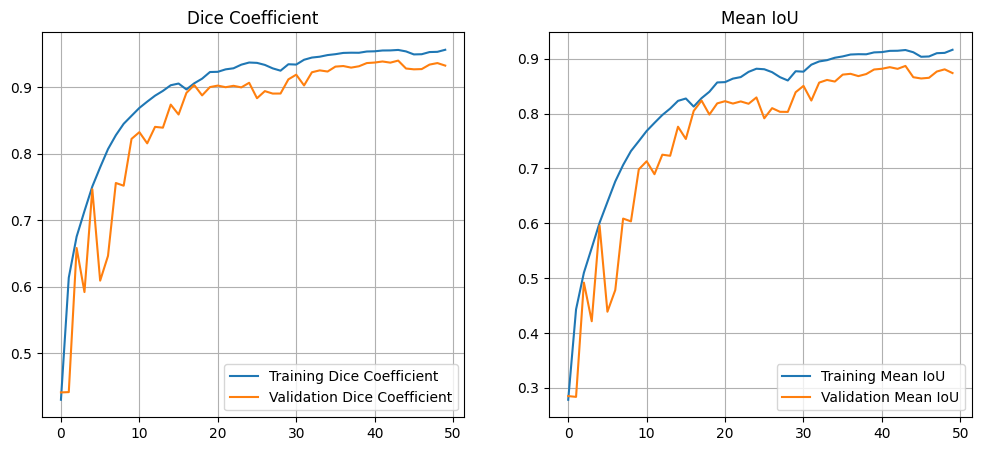

In [45]:
# Plot Dice coefficient and mean IoU during training and validation
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['dice_coefficient'], label='Training Dice Coefficient')
plt.plot(history.history['val_dice_coefficient'], label='Validation Dice Coefficient')
plt.legend()
plt.grid()
plt.title('Dice Coefficient')

plt.subplot(1, 2, 2)
plt.plot(history.history['mean_iou'], label='Training Mean IoU')
plt.plot(history.history['val_mean_iou'], label='Validation Mean IoU')
plt.legend()
plt.grid()
plt.title('Mean IoU')

plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 964ms/step


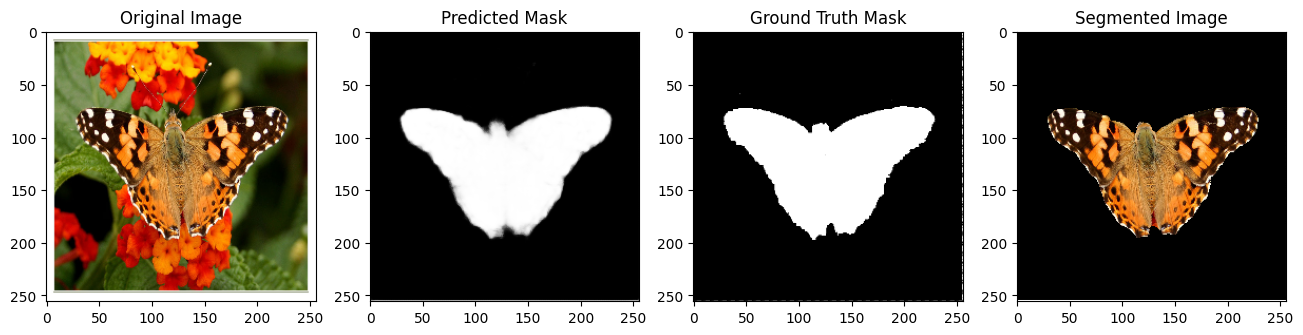

In [47]:
def visualize_segmentation_with_cropping(image, predicted_mask, ground_truth_mask):
    """
    Visualizes the original image, predicted mask, ground truth mask, and segmented image.

    Args:
        image (array): Original image.
        predicted_mask (array): Predicted mask.
        ground_truth_mask (array): Ground truth mask.
    """
    # Threshold the predicted mask to create a binary mask for segmentation
    binary_mask = (predicted_mask > 0.5).astype(np.uint8)

    # Plotting the original image, predicted mask, ground truth mask, and segmented image
    plt.figure(figsize=(16, 4))

    plt.subplot(1, 4, 1)
    plt.imshow(image)
    plt.title('Original Image')

    plt.subplot(1, 4, 2)
    plt.imshow(predicted_mask, cmap='gray')
    plt.title('Predicted Mask')

    plt.subplot(1, 4, 3)
    plt.imshow(ground_truth_mask, cmap='gray')
    plt.title('Ground Truth Mask')

    # Apply the binary mask to the original image to create the segmented output
    segmented_image = cv2.merge((binary_mask, binary_mask, binary_mask)) * image

    plt.subplot(1, 4, 4)
    plt.imshow(segmented_image)
    plt.title('Segmented Image')

    plt.show()

# Example usage
sample_image = X_val[0]
sample_ground_truth = y_val[0]

predicted_mask, _ = predict_single_image(sample_image, unet_model)

# Visualize the segmentation results with cropping
visualize_segmentation_with_cropping(sample_image, predicted_mask, sample_ground_truth)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


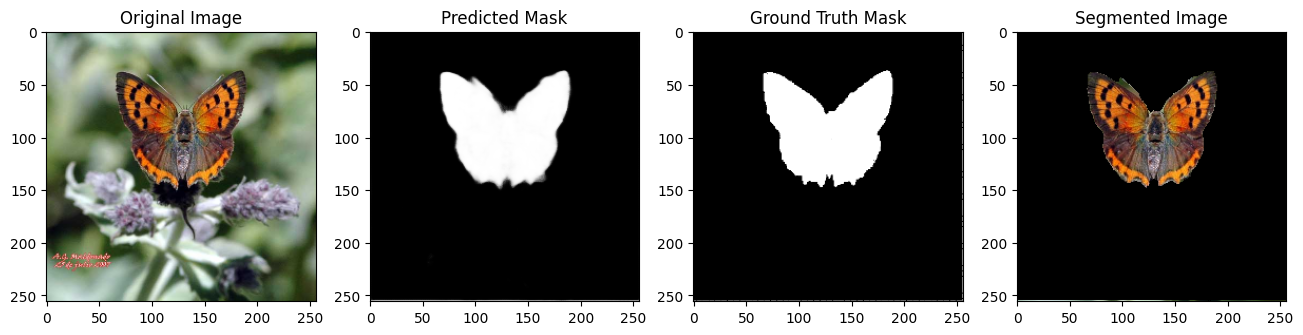

In [48]:
# Example usage
sample_image = X_val[10]
sample_ground_truth = y_val[10]

predicted_mask, _ = predict_single_image(sample_image, unet_model)

# Visualize the segmentation results with cropping
visualize_segmentation_with_cropping(sample_image, predicted_mask, sample_ground_truth)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


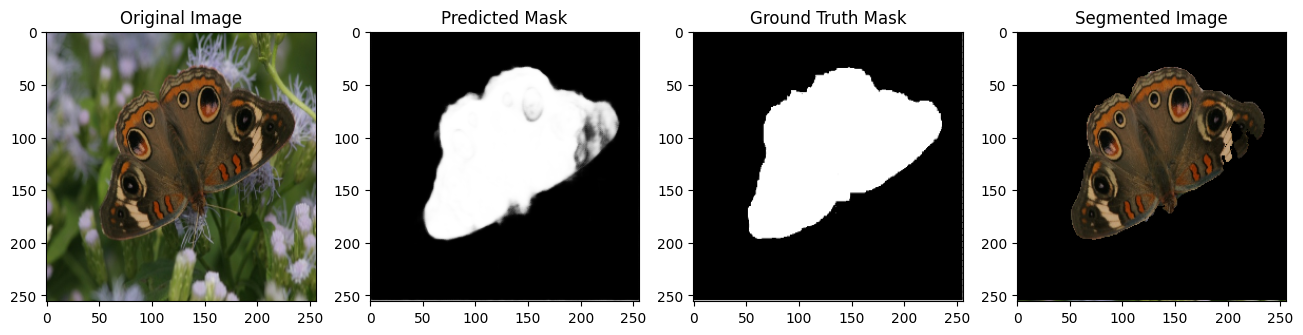

In [49]:
# Example usage
sample_image = X_val[20]
sample_ground_truth = y_val[20]

predicted_mask, _ = predict_single_image(sample_image, unet_model)

# Visualize the segmentation results with cropping
visualize_segmentation_with_cropping(sample_image, predicted_mask, sample_ground_truth)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


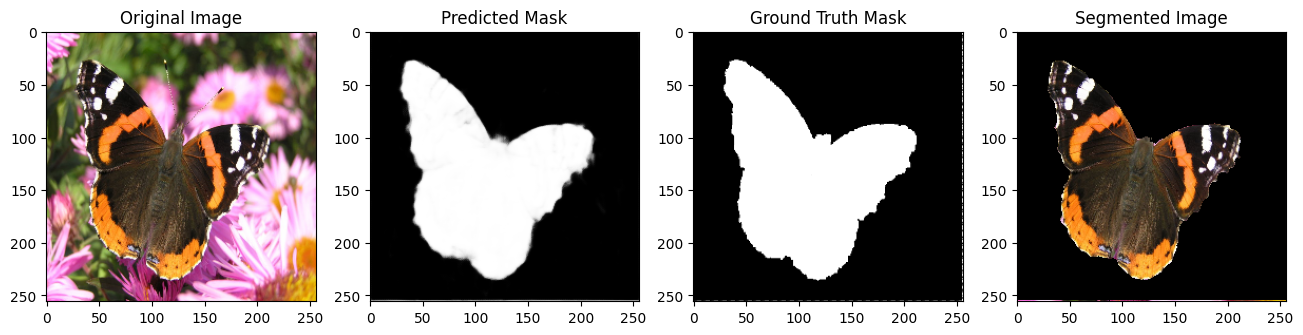

In [50]:
# Example usage
sample_image = X_val[50]
sample_ground_truth = y_val[50]

predicted_mask, _ = predict_single_image(sample_image, unet_model)

# Visualize the segmentation results with cropping
visualize_segmentation_with_cropping(sample_image, predicted_mask, sample_ground_truth)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


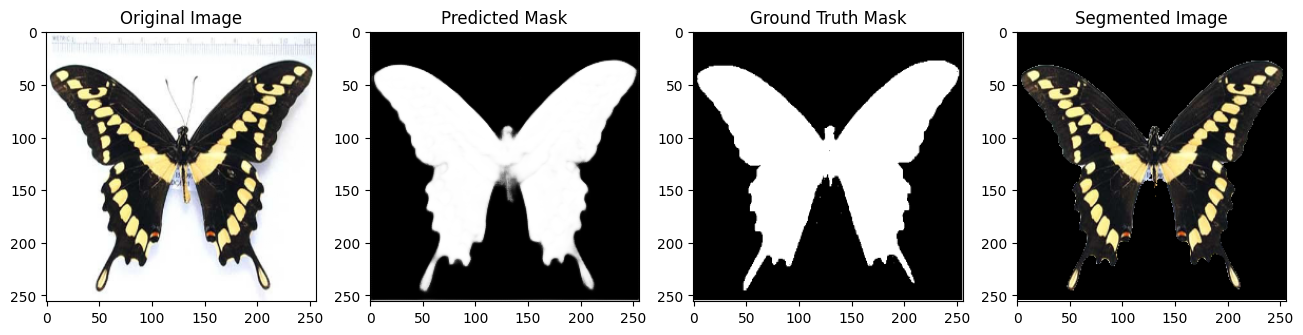

In [51]:
# Example usage
sample_image = X_val[28]
sample_ground_truth = y_val[28]

predicted_mask, _ = predict_single_image(sample_image, unet_model)

# Visualize the segmentation results with cropping
visualize_segmentation_with_cropping(sample_image, predicted_mask, sample_ground_truth)

In [52]:
unet_model.save('final_UNET_Butterfly_Segmentation.keras')